In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import os

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions

# Deklarasi folder data train

In [3]:
base_dir = r'Batu-Gunting-Kertas\Train'

os.listdir(base_dir)

['paper', 'rock', 'scissors']

# Call Image Data Generator for data Train

In [4]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.4)

# Split Dataset to Train Data

In [5]:
train_generator = train_datagen.flow_from_directory(
        base_dir,  
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        subset="training")

Found 1314 images belonging to 3 classes.


# Split Dataset to Val Data

In [6]:
validation_generator = train_datagen.flow_from_directory(
        base_dir, 
        target_size=(224, 224), 
        batch_size=32,
        shuffle=True,
        subset="validation")

Found 874 images belonging to 3 classes.


# Deklarasi folder data test

In [7]:
base_dir_test = r'Batu-Gunting-Kertas\Test'

os.listdir(base_dir_test)

['paper', 'rock', 'scissors']

# Call Image Data Generator for data test

In [8]:
test_generator = train_datagen.flow_from_directory(
        base_dir_test, 
        target_size=(224, 224), 
        batch_size=32,
        shuffle=True)

Found 2188 images belonging to 3 classes.


# Calls the VGG16 model to be used for transfer learning

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [10]:
model_transfer = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Call EarlyStopping

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_accuracy') > 0.80 ):
            self.model.stop_training = True

callbacks = myCallback()

# Call optimizer for model

In [12]:
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['categorical_accuracy'])

# Train the data 

using train_generator and validation_generator with callbacks = early_stops

In [13]:
%%time
fit = model_transfer.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[callbacks]
)

Epoch 1/20
42/42 [==============================] - 252s 6s/step - loss: 0.5937 - categorical_accuracy: 0.7953 - val_loss: 0.1713 - val_categorical_accuracy: 0.9497
Wall time: 4min 12s


# Evaluate

In [14]:
train_loss, train_acc = model_transfer.evaluate(train_generator, steps=16)
validation_loss, val_acc = model_transfer.evaluate(validation_generator, steps=16)
test_loss, test_acc = model_transfer.evaluate(test_generator, steps=16)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

16/16 [==============================] - 73s 5s/step - loss: 0.1733 - categorical_accuracy: 0.9473

Train: 0.936, val: 0.947, test: 0.947,


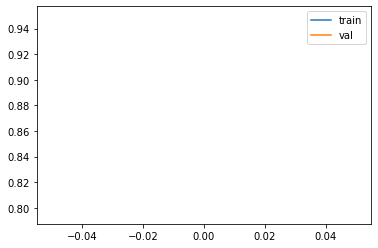

In [15]:
plt.plot(fit.history['categorical_accuracy'], label='train')
plt.plot(fit.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

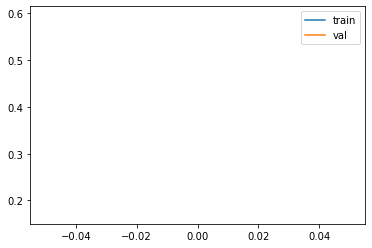

In [16]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='val')
plt.legend()
plt.show()

# Save model

In [17]:
filename = 'model_transfer.h5'
model_transfer.save(filename)